In [62]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sqlite3

In [28]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
df = df[['Close']]
df.head(5)

,Close
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011


In [29]:
df.sort_index(inplace=True)
temp = df.copy(deep=True)
temp['Close_1'] = df['Close']
temp['Close_2'] = df['Close'].shift(-1)
temp['Close_3'] = df['Close'].shift(-2)
temp['Close'] = temp['Close'].shift(-3)
temp.dropna(inplace=True)
print(len(temp))
temp.head(5)

410


,Close,Close_1,Close_2,Close_3
Date,,,,
1990-01-01,330.799988,329.079987,331.890015,339.940002
1990-02-01,361.230011,331.890015,339.940002,330.799988
1990-03-01,358.019989,339.940002,330.799988,361.230011
1990-04-01,356.149994,330.799988,361.230011,358.019989
1990-05-01,322.559998,361.230011,358.019989,356.149994


# Designing ANN Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [31]:
class Model(nn.Module):
    def __init__(self, in_features=3, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 20)
        self.out = nn.Linear(20,out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x
    
    def predict(self, test):
        with torch.no_grad():
            y_eval = self.forward(test)
            return y_eval



In [32]:
X = temp[['Close_1','Close_2','Close_3']]
y = temp['Close']

In [33]:
X = X.to_numpy()
y = y.to_numpy()

In [34]:
len(temp) * 0.8

328.0

In [35]:
X_train = X[:320]
y_train = y[:320]
X_test = X[320:]
y_test = y[320:]

In [36]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

y_train = y_train.float()
y_test = y_test.float()

In [37]:
torch.manual_seed(41)
model = Model()
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [38]:
epochs = 100
losses = []
for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train.unsqueeze(1))
    losses.append(loss.detach().numpy())
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and loss: 1297273.75
Epoch: 10 and loss: 34453.8984375
Epoch: 20 and loss: 48506.2734375
Epoch: 30 and loss: 17262.419921875
Epoch: 40 and loss: 3238.39111328125
Epoch: 50 and loss: 5551.5283203125
Epoch: 60 and loss: 3147.411376953125
Epoch: 70 and loss: 3375.711669921875
Epoch: 80 and loss: 3025.038330078125
Epoch: 90 and loss: 3030.96044921875


Text(0.5, 0, 'Epoch')

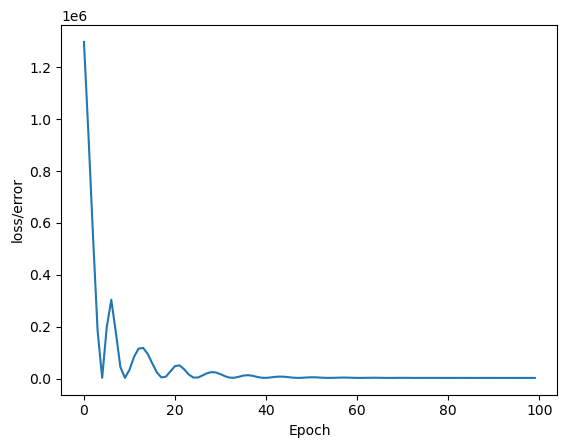

In [39]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

In [40]:
y_eval = model.predict(X_test)
print(len(y_eval),len(y_test))

90 90


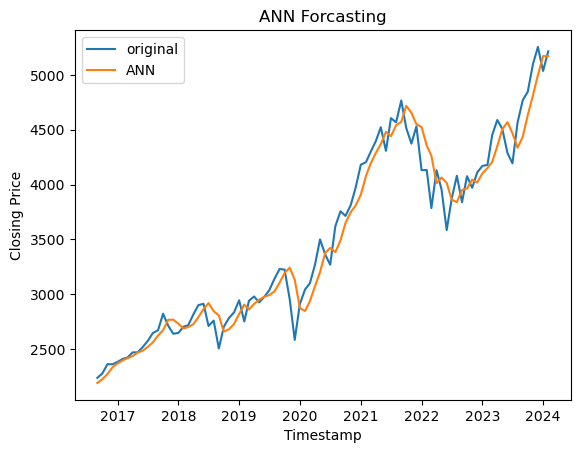

In [41]:
plt.plot(temp[320:].index,y_test,label="original")
plt.plot(temp[320:].index,y_eval,label='ANN')
plt.xlabel('Timestamp')
plt.ylabel('Closing Price')
plt.title('ANN Forcasting')
plt.legend()
plt.show()

In [19]:
temp = []
temp2 = []
for i in y_eval:
    temp.append(float(i))
for i in y_test:
    temp2.append(float(i))

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(temp2, temp)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(np.array(temp2), np.array(temp))
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(np.array(temp2), np.array(temp))
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(temp2, temp)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 31771.442
Symmetric Mean Absolute Percentage Error: 3.832
Mean Absolute Percenatage Error:3.860
R2-Score:0.954


In [51]:
pred = []
for i in y_eval:
    pred.append(float(i))
pred[:5]

[2192.09521484375,
 2225.131103515625,
 2272.64990234375,
 2334.33984375,
 2369.604736328125]

In [46]:
test = df[323:]
print(len(test),len(pred))

90 90


In [47]:
temp_ANN = pd.DataFrame({'Timestamp': test.index, 'Predicted': pred})
temp_ANN.head(5)

,Timestamp,Predicted
0,2016-12-01,2192.095215
1,2017-01-01,2225.131104
2,2017-02-01,2272.649902
3,2017-03-01,2334.339844
4,2017-04-01,2369.604736


In [308]:
torch.save(model, r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\ANN.pt')

In [52]:
history = [pred[-3],pred[-2],pred[-1]]
new_pred = []
for i in range(36):
    _pred = model.predict(torch.FloatTensor(history))
    history.append(float(_pred))
    history.pop(0)
    new_pred.append(float(_pred))

In [54]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

start_date = datetime(2024, 6, 1)
end_date = start_date + relativedelta(months=+36)
monthly_dates = [start_date + relativedelta(months=+i) for i in range(0, 36)]
final = []
for date in monthly_dates:
    final.append(date.strftime('%Y-%m-%d'))

In [55]:
further_ANN = pd.DataFrame({'Timestamp': final, 'Predicted': new_pred})
further_ANN.head(5)

,Timestamp,Predicted
0,2024-06-01,5187.237305
1,2024-07-01,5232.383301
2,2024-08-01,5259.190430
3,2024-09-01,5289.833008
4,2024-10-01,5322.713867


In [56]:
result = pd.concat([temp_ANN,further_ANN])
result['Timestamp'] = pd.to_datetime(result['Timestamp'])

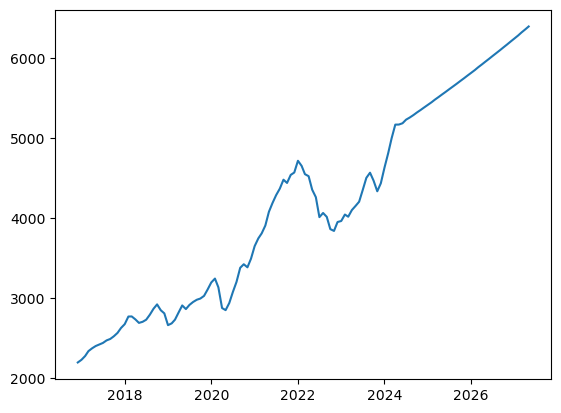

In [57]:
plt.plot(result['Timestamp'],result['Predicted'])

In [63]:
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
result.to_sql('ANN_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

# HYBRID MODEL USING ARIMA AND ANN

In [373]:
ANN = torch.load(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\ANN.pt')

In [374]:
train = df[:328]
test = df[328:]
train.head(1)

,Close
Date,
1990-01-01,329.079987


In [368]:
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA


train_ar_m = train['Close'].values
test_ar_m = test['Close'].values
history = [x for x in train_ar_m]
final = []
print(type(history))
for t in tqdm(range(len(test_ar_m))):
    model = ARIMA(history, order=(5,1,0))
    arima_fit = model.fit()
    output = arima_fit.forecast()
    yhat = output[0]
    new = ANN.predict(torch.FloatTensor([history[-2],history[-1],yhat]))
    final.append(float(new))
    obs = test_ar_m[t]
    history.append(float(new))
print('Monthly Basis Forecasting Perfomance')

<class 'list'>


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:26<00:00,  3.24it/s]

Monthly Basis Forecasting Perfomance


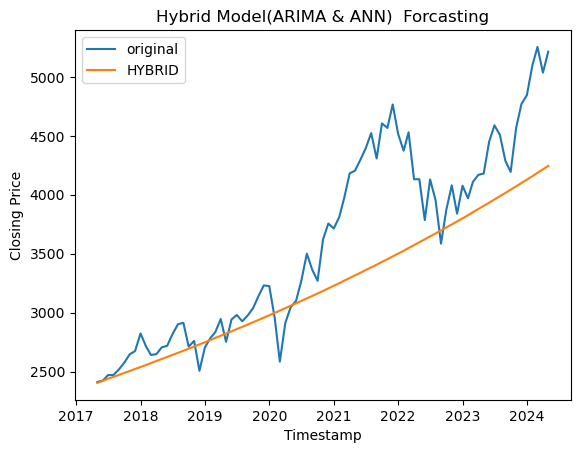

In [370]:
plt.plot(test.index,test['Close'],label="original")
plt.plot(test.index,final,label='HYBRID')
plt.xlabel('Timestamp')
plt.ylabel('Closing Price')
plt.title('Hybrid Model(ARIMA & ANN)  Forcasting')
plt.legend()
plt.show()

In [347]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(test['Close'],final)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(test['Close'],final)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(test['Close'],final)
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(test['Close'],final)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 31178.777
Symmetric Mean Absolute Percentage Error: 3.877
Mean Absolute Percenatage Error:3.901
R2-Score:0.952


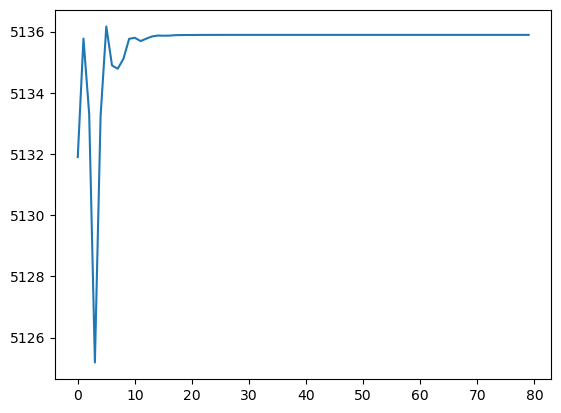

In [363]:
plt.plot(x,t_final[:-1],label="original")

In [351]:
len(history)

493